In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/covid-19-nlp-text-classification/Corona_NLP_test.csv
/kaggle/input/covid-19-nlp-text-classification/Corona_NLP_train.csv


In [2]:
import numpy as np
import pandas as pd
import nltk
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
import pickle
import time
import re

In [3]:
train_set = pd.read_csv('../input/covid-19-nlp-text-classification/Corona_NLP_train.csv',encoding="latin1")
test_set = pd.read_csv('../input/covid-19-nlp-text-classification/Corona_NLP_test.csv',encoding="latin1")

train_set.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [4]:
unrelevant_features = ["UserName","ScreenName","Location","TweetAt"]

train_set.drop(unrelevant_features,inplace=True,axis=1)
test_set.drop(unrelevant_features,inplace=True,axis=1)
train_set.head()

,OriginalTweet,Sentiment
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,advice Talk to your neighbours family to excha...,Positive
2,Coronavirus Australia: Woolworths to give elde...,Positive
3,My food stock is not the only one which is emp...,Positive
4,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [5]:
train_set["Sentiment"].value_counts()

Positive              11422
Negative               9917
Neutral                7713
Extremely Positive     6624
Extremely Negative     5481
Name: Sentiment, dtype: int64

In [6]:
positives = train_set[(train_set["Sentiment"] == "Positive") | (train_set["Sentiment"] == "Extremely Positive")]
positives_test = test_set[(test_set["Sentiment"] == "Positive") | (test_set["Sentiment"] == "Extremely Positive")]
print(positives["Sentiment"].value_counts())
positives.head()

Positive              11422
Extremely Positive     6624
Name: Sentiment, dtype: int64


,OriginalTweet,Sentiment
1,advice Talk to your neighbours family to excha...,Positive
2,Coronavirus Australia: Woolworths to give elde...,Positive
3,My food stock is not the only one which is emp...,Positive
5,As news of the regionÂs first confirmed COVID...,Positive
6,Cashier at grocery store was sharing his insig...,Positive


In [7]:
negatives = train_set[(train_set["Sentiment"] == "Negative") | (train_set["Sentiment"] == "Extremely Negative")]
negatives_test = test_set[(test_set["Sentiment"] == "Negative") | (test_set["Sentiment"] == "Extremely Negative")]
print(negatives["Sentiment"].value_counts())
negatives.head()

Negative              9917
Extremely Negative    5481
Name: Sentiment, dtype: int64


,OriginalTweet,Sentiment
4,"Me, ready to go at supermarket during the #COV...",Extremely Negative
9,"For corona prevention,we should stop to buy th...",Negative
20,with 100 nations inficted with covid 19 th...,Extremely Negative
24,@10DowningStreet @grantshapps what is being do...,Negative
26,In preparation for higher demand and a potenti...,Negative


In [8]:
neutrals = train_set[train_set["Sentiment"] == "Neutral"]
neutrals_test = test_set[test_set["Sentiment"] == "Neutral"]
print(neutrals["Sentiment"].value_counts())
neutrals.head()

Neutral    7713
Name: Sentiment, dtype: int64


,OriginalTweet,Sentiment
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
7,Was at the supermarket today. Didn't buy toile...,Neutral
10,All month there hasn't been crowding in the su...,Neutral
16,????? ????? ????? ????? ??\r\r\n?????? ????? ?...,Neutral
17,@eyeonthearctic 16MAR20 Russia consumer survei...,Neutral


In [9]:
import warnings as wrn
wrn.filterwarnings('ignore')

negatives["Sentiment"] = 0 
negatives_test["Sentiment"] = 0

positives["Sentiment"] = 2
positives_test["Sentiment"] = 2

neutrals["Sentiment"] = 1
neutrals_test["Sentiment"] = 1

negatives.head()

,OriginalTweet,Sentiment
4,"Me, ready to go at supermarket during the #COV...",0
9,"For corona prevention,we should stop to buy th...",0
20,with 100 nations inficted with covid 19 th...,0
24,@10DowningStreet @grantshapps what is being do...,0
26,In preparation for higher demand and a potenti...,0


In [10]:
#Now I will concatenate train and test, I will split them after processing.
data = pd.concat([positives,
                  positives_test,
                  neutrals,
                  neutrals_test,
                  negatives,
                  negatives_test
                 ],axis=0)

data.reset_index(inplace=True)

In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44955 entries, 0 to 44954
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   index          44955 non-null  int64 
 1   OriginalTweet  44955 non-null  object
 2   Sentiment      44955 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 1.0+ MB


In [12]:
#And let's take a look at the frequency distributions.

positiveFD = nltk.FreqDist(word for text in data[data["Sentiment"] == 2]["OriginalTweet"] for word in text.lower().split())
negativeFD = nltk.FreqDist(word  for text in data[data["Sentiment"] == 0]["OriginalTweet"] for word in text.lower().split())
neutralDF = nltk.FreqDist(word  for text in data[data["Sentiment"] == 1]["OriginalTweet"] for word in text.lower().split())

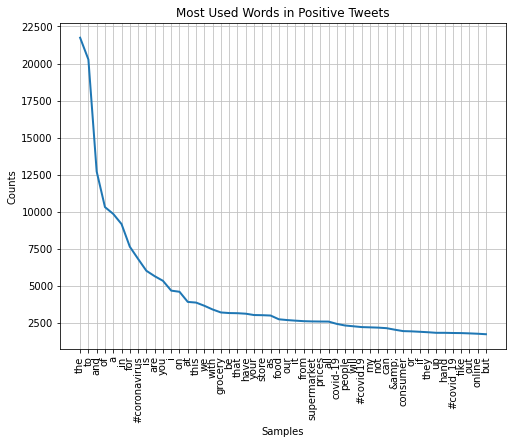

In [13]:
#And now we can examine most used words plots.

plt.subplots(figsize=(8,6))
plt.title("Most Used Words in Positive Tweets")
positiveFD.plot(50)
plt.show()

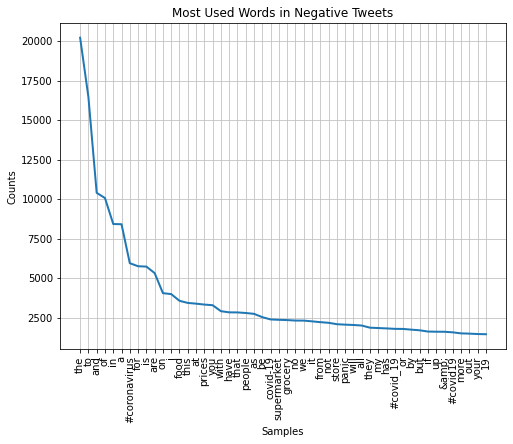

In [14]:
plt.subplots(figsize=(8,6))
plt.title("Most Used Words in Negative Tweets")
negativeFD.plot(50)
plt.show()

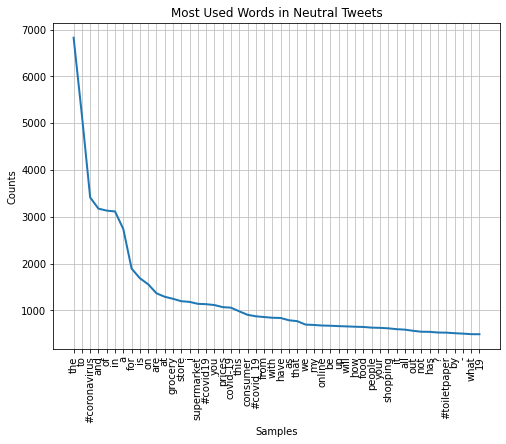

In [15]:
plt.subplots(figsize=(8,6))
plt.title("Most Used Words in Neutral Tweets")
neutralDF.plot(50)
plt.show()

In [16]:
cleanedData = []

lemma = WordNetLemmatizer()
swords = stopwords.words("english")
for text in data["OriginalTweet"]:
    
    # Cleaning links
    text = re.sub(r'http\S+', '', text)
    
    # Cleaning everything except alphabetical and numerical characters
    text = re.sub("[^a-zA-Z0-9]"," ",text)
    
    # Tokenizing and lemmatizing
    text = nltk.word_tokenize(text.lower())
    text = [lemma.lemmatize(word) for word in text]
    
    # Removing stopwords
    text = [word for word in text if word not in swords]
    
    # Joining
    text = " ".join(text)
    
    cleanedData.append(text)
    
    
    
for i in range(0,5):
    print(cleanedData[i],end="\n\n")

advice talk neighbour family exchange phone number create contact list phone number neighbour school employer chemist gp set online shopping account po adequate supply regular med order

coronavirus australia woolworth give elderly disabled dedicated shopping hour amid covid 19 outbreak

food stock one empty please panic enough food everyone take need stay calm stay safe covid19france covid 19 covid19 coronavirus confinement confinementotal confinementgeneral

news region first confirmed covid 19 case came sullivan county last week people flocked area store purchase cleaning supply hand sanitizer food toilet paper good tim dodson report

cashier grocery store wa sharing insight covid 19 prove credibility commented civics class know talking



In [17]:
#create bag of words model

vectorizer = CountVectorizer(max_features=10000)
BOW = vectorizer.fit_transform(cleanedData)

In [18]:
#now split into train and test
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(BOW,np.asarray(data["Sentiment"]))

print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(33716, 10000)
(11239, 10000)
(33716,)
(11239,)


In [19]:
from sklearn.svm import SVC
start_time = time.time()

model = SVC()
model.fit(x_train,y_train)

end_time = time.time()
process_time = round(end_time-start_time,2)
print("Fitting SVC took {} seconds".format(process_time))

Fitting SVC took 702.36 seconds


In [20]:
predictions = model.predict(x_test)

In [21]:
from sklearn.metrics import accuracy_score,confusion_matrix

print("Accuracy of model is {}%".format(accuracy_score(y_test,predictions) * 100))

Accuracy of model is 77.3912269774891%
